# Train a model using fast.ai

Now it is your turn to train a model on this same dataset using fast.ai!

## Setup

### Import necessary libraries

In [34]:
# This file contains all the main external libs we'll use
from fastai.imports import * #used for fastai
from IPython import display #used to display media in notebook
import matplotlib.pyplot as plt #used to plot in notebook

from fastai.data.all import *
from fastai.data.external import *
from fastai.vision.all import *

import librosa;
import librosa.display;

import PIL as Pillow;

### Check if CUDA is available - This will be a problem later if this doesn't work

In [3]:
print(torch.cuda.is_available())

True


### Setup dataset paths

In [5]:
DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_data'))
SAMPLE_DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'sample_data'))

DATA_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'whale')
DATA_NOT_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'not_whale')
path = Path(DATA_ROOT_DIR)

### Create Fast.AI Transformer to Load Audio to Spectrogram

In [31]:
# This code takes a single channel image (greyscale) and converts it into a 3-channel image (RGB)
# It also normalizes so that all values are between [0,255]
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

# Lots of libraries and methods for generating a spectrogram
# Under the hood all these algorithms rely on a Fast Fourier Transform
# Originally, I wanted to use torchaudio because that is CUDA enabled and can be accelerated on GPU
# Unfortunately, the shape of the data returned simply did not make any sense and working with tensors
# as opposed to numpy arrays was incredibly annoying. It just didn't work.
# I tried other libraries as well but ultimately settled on librosa since it seems the most widely used
# There exist fast.ai packages like fastaudio and other forks but like many open-source things they are unmaintained
# Using those type of packages breaks the dependencies and on my environment forced a non-CUDA
# accelerated version of pytorch which is useless
def create_spectrogram(file_path):
    samples, sample_rate = librosa.core.load(file_path)
    
    # Compute spectrogram, using some sensible defaults
    # Opportunities here to tweak possibly, just not sure how much it would help
    # We don't use Nicholas' settings as for some reason they get bad results with this library
    D = librosa.stft(samples, n_fft=512, hop_length=64, window="han", center=False)  # STFT of y
    
    # Normalize to decibals
    S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_dB, sample_rate

# This is an alternative type of spectrogram.
# My understanding is that it normalizes the spectrogram based on what humans can perceive which is
# Settings here are open to tweaking
def create_mel_spectrogram(audio):
    audio, sample_rate = librosa.core.load(audio)
    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, fmax=1000, center=False)
    
    # Normalize to decibals
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sample_rate


# Converts a spectrogram (numpy) to a 3-channel (RGB) Fast.AI Image
def spectrogram_to_image(spec):
    
    # Most vision models in fast.ai use images with three channels (RGB)
    # spectrogram functions don't return images, they return data
    # plot libraries like matplotlib help us visualize the data as an image, but it is not an image
    # it is a multi-dimensional array-like object whose values can be positive or negative
    
    # We need to convert it from this format into a 3 channel (RGB) whose values are bounded between [0, 255]
    colored_np = mono_to_color(spec)
    
    # Pillow is a fork of PIL (standard Python image library), we consider Pillow.Image to be regular Python images
    # In order to use Pillow features like crop, we have to convert the image from numpy into PIL (Pillow)
    pillow_image = Pillow.Image.fromarray(colored_np) # convert to regular python image
    
    # When you manually convert a spectrogram to an image without using matplotlib you have to flip it vertically
    flipped_image = pillow_image.transpose(Image.FLIP_TOP_BOTTOM) # flip image
    
    # This will crop the image by taking from the height to make a square
    h, w, *other = pillow_image.shape
    cropped_image = flipped_image.crop((0, h-w, w, h))
    cropped_image_np = np.array(cropped_image) # back to numpy
        
    # Kinda confusing but fast.ai has a class called PILImage and so we convert our real PIL image into a fast.ai one
    fast_ai_image = PILImage.create(cropped_image_np)
    return fast_ai_image


# I chose to load the audio files directly into fast.ai using the DataBlock API.
# Alternatively, we could have pre-computed all the spectrograms in the 00_getting_started.ipynb but
# I decided against it because then it would be unlikely for anyone to actually make modifications to the images
# Writing 40,000 files to disk is painfully slow so you wouldn't even be able to get started quickly
# This method creates a transformer which can take paths to audio files and transform them into spectrogram images.
# If you do some research you will see lots of people doing pretty terrible things involving file.io because
# it is not easy to figure out how to turn a spectrogram into a 3-channel image and further how to get that
# into a fast.ai image. This solution is pretty clever because since it is all in-memory it is insanely fast and
# does not rely on any type of pre-computation.
class SpecgramTransform(Transform):
    def __init__(self): self.aug = create_spectrogram
    def encodes(self, audio_file: Path):
        aug_img, sample_rate = self.aug(audio_file)
        image = spectrogram_to_image(aug_img)
        return image

# Alternative transformer for generating images of Mel Spectrograms
class MelSpecgramTransform(Transform):
    def __init__(self): self.aug = create_mel_spectrogram
    def encodes(self, audio_file: Path):
        aug_img, sample_rate = self.aug(audio_file)
        image = spectrogram_to_image(aug_img)
        return image

    
# IGNORE: Unless you decide to use SpecgramTransform 
# We may need to crop images. If you use the SpecgramTransform, cropping will likely be required 
# to turn the image into a square.
# It could be reasonable to cut-off the image at frequencies we know a whale call couldn't exist
# Ultimately, images will need to be square I believe so they would need to get filled with something
# The reason I created this transform is because fast.ai doesn't give you a transformer for precision cropping
# You either crop and cut out the center or you don't crop at all
# This transformer lets you optionally crop from any direction and leaves sides alone that you don't specify crops for
class CropImageTransform(Transform):
    def __init__(self, left=None, upper=None, right=None, lower=None):
        print("test constructor")
        self.aug = self.__crop_image
        self.box = (left, upper, right, lower)
    
    def __compute_box(self, image):
        # get current dimensions of image
        # *other is because we don't know if we will receive two elements or more
        # we get two for a greyscale image, we get three for a RGB
        h, w, *other = image.shape
        
        #get desired crop entered by user
        left, upper, right, lower = self.box
        
        #don't crop sides that user didn't want cropped
        left = 0 if left is None else left
        upper = 0 if upper is None else upper
        right = w if right is None else right
        lower = h if lower is None else lower
        
        #save computed box
        self.box = (left, upper, right, lower)
        
    def __crop_image(self, image):
        print("test crop")

        self.__compute_box(image)
        print(self.box)
        image_cropped = image.crop(self.box)
        return image_cropped
        
    # this transformer works on PILImages (fast.ai)
    # this transfomer does not work on PIL.Image (Pillow/PIL)
    def encodes(self, image):
        print("encode")
        print(image)
        cropped_image = self.aug(image)
        return cropped_image

Check one file to see if data loaded correctly

<class 'fastai.vision.core.PILImage'>
Specgram Size: (83, 83)


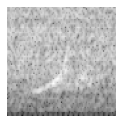

In [40]:
files = get_files(path)
audio_file = files[0]

spec, sample_rate = create_mel_spectrogram(audio_file)
spec_image = spectrogram_to_image(spec)
print(type(spec_image))
show_image(spec_image)

print(f"Specgram Size: {spec_image.shape}")

## Model Training

### Load dataset

This part maybe looks a little tricky but this uses Fast.AI's DataBlock API for generic loading. `get_files` is a generic loader that takes in everything in the `path` when you call `dblock.dataloaders(path)`. `get_files` is just a function provided by fast.ai and we are passing the function by name, but it doesn't get called yet until you use the dataloader. Since the audio files are organized in folders in the path, DataBlock/DataLoader is smart enough to know that each folder represents a category of data. 

Our data set is comprised of two types of data, audio files which we use a `TransformBlock` for and the labels which are represented by `CategoryBlock`. Based on what you pick here lets fast.ai be able to support additional features. So for example an `ImageBlock` responds to more things than a `TransformBlock`. We don't have a choice here because while we will _eventually_ load data in the form of a spectrogram image, at this moment our dataset is just a collection of file paths and labels. If we tried to use an `ImageBlock` it would throw an error saying `Path` is not of type `Image` or something like that.

Additionally, DataBlocks can have one or more item transformers and one or more batch transformers. Item transformers are executed on each item. Batch transfomers are executed on the whole batch. The default transformer pipeline I laid out here does the following:

* Transform each file path into a fast.ai friendly image of its corresponding spectrogram
* Resize the each image such that the largest dimension of that image is 224 pixels, while the other is possibly smaller
* Turn the image into a square by making all sides 224 while centering the image and padding the empty space with zeroes. Annoyingly, padding is applied randomly on the borders of the  smaller dimensions. If we hate this, we can write our own ExtendTransform. I didn't because there are arguments that this type of augmentation helps the model generalize.

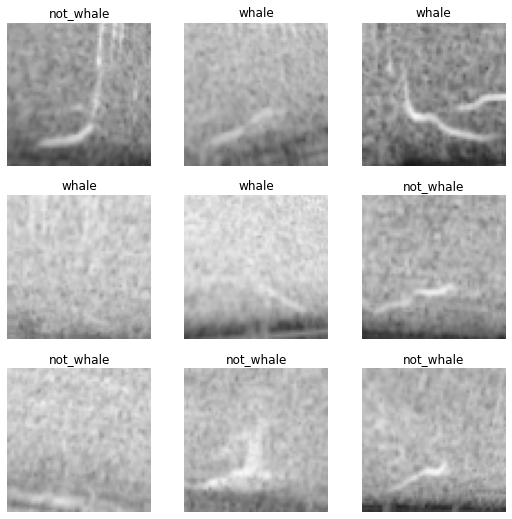

In [21]:
dblock = DataBlock(
    blocks = [TransformBlock, CategoryBlock],
    get_items = get_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = [ MelSpecgramTransform(), ToTensor(), IntToFloatTensor, RatioResize(64) ],
    batch_tfms = aug_transforms(mult=1)
)
dls = dblock.dataloaders(path)
dls.show_batch()

### Train

In [22]:
roc_auc = RocAucBinary()
learn = vision_learner(dls, resnet18, metrics=[error_rate, roc_auc], pretrained=False)
learn.model.cuda()
learn.fit(10)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.348698,0.518912,0.225833,0.895374,00:50
1,0.255381,0.318130,0.136167,0.951856,00:51
2,0.230058,0.192040,0.086000,0.968364,00:50
3,0.212502,0.196438,0.086000,0.967038,00:49
4,0.198600,0.252292,0.097167,0.969079,00:50
5,0.209016,0.172348,0.075167,0.974480,00:50
6,0.204233,0.196416,0.083833,0.968902,00:50
7,0.187126,0.176175,0.079667,0.974489,00:50
8,0.195484,0.174034,0.075167,0.974029,00:49
9,0.183292,0.196676,0.084667,0.968845,00:49


### Confusion Matrix

Create a confusion matrix to analyze results.

How-to: https://www.youtube.com/watch?v=F4tvM4Vb3A0&t=1142s

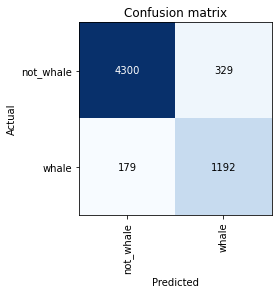

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Show Top Losses

Show the top misclassified samples. Metrics alone don't tell the whole story. Yes some things will be misclassified but in order to evaluate the real world usefulness of the models we train we should analyze _how_ was the model wrong. In our dataset, we would want to err on the side of saying something is a whale when it isn't as opposed to saying something is not a whale and having a ship collide with it due to the mistakes in our model.

Hint: if you get errors about not being able to calculate a metric its just that we aren't showing enough examples. Boost the number of examples to plot. Don't forget to add more rows otherwise it will fail to render the plot correctly.

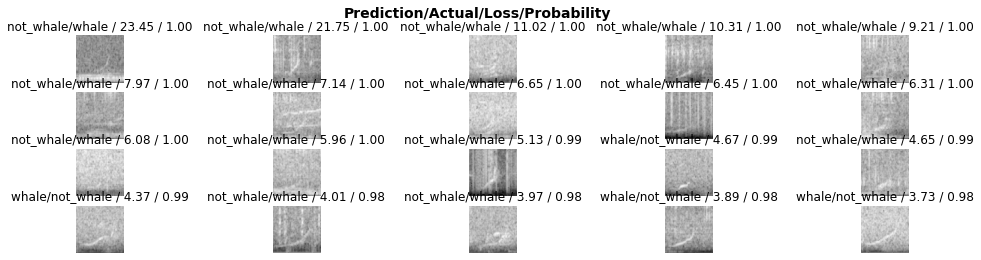

In [29]:
interp.plot_top_losses(20, nrows=4, figsize=(17,4))

### Export

In [30]:
learn.export('model.pkl')

## Brainstorm ideas for improvement

Don't improve things in this notebook. Save it for the later one. But just jot down some ideas you can think of to improve the results.

* todo by you